# Data Description
In this project we'll work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. More infos about the data set can be found [here](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf) and [here](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt).

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn import linear_model

In [67]:
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
df.head()
print(df.shape)

(2930, 82)


In [68]:
def transform_features(df):
    return df

def select_feature(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    
    #选择numerical列来训练模型
    numeric_train = train.select_dtypes(include = ['integer', 'float'])
    numeric_train = test.select_dtypes(include = ['integer', 'float'])
    
    features = numeric_train.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

transform_df = transform_features(df)
filtered_df = select_feature(transform_df)
rmse = train_and_test(filtered_df)

rmse

57088.251612639091

## Feature Engineering
* Handle missing values(drop columns)
    * All columns:
        * Drop any with 5% or more mising values **for now**
    * Text columns:
        * Drop any with 1 or more missing values **for now**
    * Numerical columns:
        * For columns with missing values, fill in with most commom value in that column

如果drop行的话，就会大大减少数据量，不是我们想要的。

1: All columns: Drop any with 5% or more mising values **for now**

In [69]:
missing_values = df.isnull().sum()
missing_values

Order                0
PID                  0
MS SubClass          0
MS Zoning            0
Lot Frontage       490
Lot Area             0
Street               0
Alley             2732
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type        23
Mas Vnr Area        23
Exter Qual           0
Exter Cond           0
                  ... 
Bedroom AbvGr        0
Kitchen AbvGr        0
Kitchen Qual         0
TotRms AbvGrd        0
Functional           0
Fireplaces           0
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual

In [70]:
drop_missing_cols = missing_values[(missing_values / len(df)) > 0.05].sort_values()
df = df.drop(drop_missing_cols.index, axis = 1)

2: Text columns: Drop any with 1 or more missing values for now.

In [71]:
# 注意在统计text类型的null时，要先选择（筛选），再统计。
text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
text_mv_counts

Bsmt Exposure     83
BsmtFin Type 2    81
BsmtFin Type 1    80
Bsmt Qual         80
Bsmt Cond         80
Mas Vnr Type      23
Electrical         1
Utilities          0
Lot Config         0
Land Slope         0
Roof Matl          0
Land Contour       0
Lot Shape          0
Street             0
Neighborhood       0
Condition 1        0
Condition 2        0
Bldg Type          0
House Style        0
Roof Style         0
Sale Condition     0
Exterior 1st       0
Exterior 2nd       0
Sale Type          0
Exter Qual         0
Exter Cond         0
Foundation         0
Heating            0
Heating QC         0
Central Air        0
Kitchen Qual       0
Functional         0
Paved Drive        0
MS Zoning          0
dtype: int64

In [72]:
drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
df = df.drop(drop_missing_cols_2.index, axis=1)
df.shape

(2930, 64)

3: Numerical columns: For columns with missing values, fill in with the most common value in that column

In [73]:
## Compute column-wise missing value counts
num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
fixable_numeric_cols

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [74]:
## Compute the most common value for each column in `fixable_nmeric_missing_cols`.
replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
replacement_values_dict

{'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Bsmt Unf SF': 0.0,
 'Total Bsmt SF': 0.0,
 'Garage Cars': 2.0,
 'Garage Area': 0.0,
 'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Mas Vnr Area': 0.0}

In [75]:
df = df.fillna(replacement_values_dict)

In [76]:
# 验证missing value处理得当
df.isnull().sum().value_counts()

0    64
dtype: int64

对于一些是numerical，但是表示的是没有实际意义的『numerical』的那些列，进行适当的处理。（比如年份，处理成房子从建成到出售的时间差，一座房子的年限，会影响房价）

In [77]:
years_sold = df['Yr Sold'] - df['Year Built']
years_sold[years_sold<0] #筛选出那些不正常的（还没建好就卖的）

2180   -1
dtype: int64

In [78]:
years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [79]:
## Create new columns
df['Years Before Sale'] = years_sold
df['Years Since Remod'] = years_since_remod

## Drop rows with negative values for both of these new features
df = df.drop([1702, 2180, 2181], axis=0) #drop行

## No longer need original year columns
df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)

再进一步处理

In [80]:
## Drop columns that aren't useful for ML
df = df.drop(["PID", "Order"], axis=1)

## Drop columns that leak info about the final sale
df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

### 现在我们把上面的处理过程汇总到transform_features()函数中

In [81]:
def transform_features(df):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df

def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):  
    train = df[:1460]
    test = df[1460:]
    
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    features = numeric_train.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

55275.367312413073

对比没有进行features transform时的rmse, transform后，rmse减少了不少。

## Feature Selection
经过处理后的features虽然可以直接用了，但是我们肯定不想用所有的feature, 因为这些feature之间所带信息可能有重复的，通过筛选，可以使我们的模型准确率更高。

In [82]:
numerical_df = transform_df.select_dtypes(include=['int', 'float'])
numerical_df

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Yr Sold,SalePrice,Years Before Sale,Years Since Remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,...,62,0,0,0,0,0,2010,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,...,0,0,0,120,0,0,2010,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,...,36,0,0,0,0,12500,2010,172000,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,...,0,0,0,0,0,0,2010,244000,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,...,34,0,0,0,0,0,2010,189900,13,12
5,60,9978,6,6,20.0,602.0,0.0,324.0,926.0,926,...,36,0,0,0,0,0,2010,195500,12,12
6,120,4920,8,5,0.0,616.0,0.0,722.0,1338.0,1338,...,0,170,0,0,0,0,2010,213500,9,9
7,120,5005,8,5,0.0,263.0,0.0,1017.0,1280.0,1280,...,82,0,0,144,0,0,2010,191500,18,18
8,120,5389,8,5,0.0,1180.0,0.0,415.0,1595.0,1616,...,152,0,0,0,0,0,2010,236500,15,14
9,60,7500,7,5,0.0,0.0,0.0,994.0,994.0,1028,...,60,0,0,0,0,0,2010,189000,11,11


In [83]:
abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
abs_corr_coeffs

BsmtFin SF 2         0.006127
Misc Val             0.019273
Yr Sold              0.030358
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice 

选取那些与target column(SalePrice)相关性为0.3的feature(0.3是随意的，可以通过多次实验进行选择一个合适的值）

In [84]:
abs_corr_coeffs[abs_corr_coeffs > 0.3]

Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: SalePrice, dtype: float64

In [85]:
## Drop columns with less than 0.3 correlation with SalePrice
transform_df = transform_df.drop(abs_corr_coeffs[abs_corr_coeffs < 0.3].index, axis=1)
transform_df

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,...,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,SalePrice,Years Before Sale,Years Since Remod
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,Typ,2,2.0,528.0,P,210,62,215000,50,50
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,...,Typ,0,1.0,730.0,Y,140,0,105000,49,49
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,Typ,0,1.0,312.0,Y,393,36,172000,52,52
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,Typ,2,2.0,522.0,Y,0,0,244000,42,42
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,Typ,1,2.0,482.0,Y,212,34,189900,13,12
5,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,Typ,1,2.0,470.0,Y,360,36,195500,12,12
6,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,...,Typ,0,2.0,582.0,Y,0,0,213500,9,9
7,RL,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,...,Typ,0,2.0,506.0,Y,0,82,191500,18,18
8,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,...,Typ,1,2.0,608.0,Y,237,152,236500,15,14
9,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,Typ,1,2.0,442.0,Y,140,60,189000,11,11


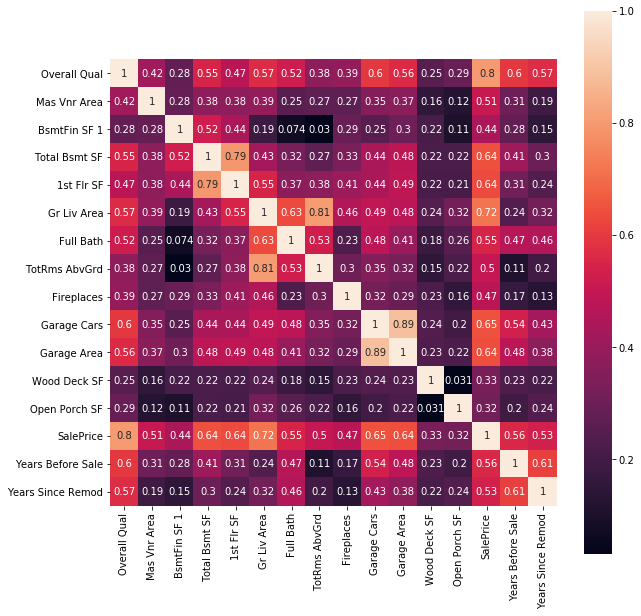

In [86]:
corrmat = transform_df.corr().abs()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, annot=True, annot_kws={'size': 10}, ax=ax, square= True) #用heatmap显示属性与属性之间的相关性

which categorical columns should we keep?

In [87]:
# 选出所有列（原数据集）中，所有的categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

* Which columns are currently numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)?
* If a categorical column has hundreds of unique values (or categories), should we keep it? When we dummy code this column, hundreds of columns will need to be added back to the data frame.

In [88]:
## Which categorical columns have we still carried with us? We'll test these  
transform_cat_cols = []
for col in nominal_features:
    if col in transform_df.columns:
        transform_cat_cols.append(col)

## How many unique values in each categorical column?
uniqueness_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
## Aribtrary cutoff of 10 unique values (worth experimenting)
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
transform_df = transform_df.drop(drop_nonuniq_cols, axis=1)

In [89]:
## Select just the remaining text columns and convert to categorical
text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')
    
## Create dummy columns and add back to the dataframe!
transform_df = pd.concat([
    transform_df, 
    pd.get_dummies(transform_df.select_dtypes(include=['category']))
], axis=1)

## 将上面的步骤汇总到select_features()中，并更改test_train函数，以使用KFold
这样做，能方便我们多做几次实验，以确定最佳效果（比如，确定到底选关联系数是0.3的好还是0.4的好等）

In [90]:
from sklearn.model_selection import cross_val_score
def  transform_featurestransform (df):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df

def select_features(df, coeff_threshold=0.3, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > uniq_threshold].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1)
    
    return df

def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k==1:
        # Randomize *all* rows (frac=1) from `df` and return, 将顺序打乱很重要，
        # Kfold函数已经帮你打乱过了
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    
    else:
        kf = KFold(n_splits=k, shuffle=True)
        mses = cross_val_score(lr, df[features], df[["SalePrice"]],
                              scoring="neg_mean_squared_error", cv=kf)
        rmses = np.sqrt(np.absolute(mses))
        print(rmses)
        avg_rmse = np.mean(rmses)
        return avg_rmse
    
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)

rmse

[ 28274.12957365  28593.03000179  36455.37253396  24577.34831616]


29474.970106387325

For More: 可以参考 [Kaggle kernels page](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels).